# RNN with LSTMCell for japanese character classification

In [1]:
from google.colab import drive, files
import os
drive.mount("/content/gdrive")
%cd gdrive/My Drive/Colab\ Notebooks/
if not os.path.exists('japanese-character-classification'):
    !git clone https://github.com/erikhelmut/japanese-character-classification.git
    %cd japanese-character-classification/notebooks/
else:
    %cd japanese-character-classification/notebooks/
    !git pull
#%pip install -r requirements.txt

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks
/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification
Already up to date.


In [1]:
import time
import math
import random

import sys
import inspect
import os
import glob
import csv

import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from src.data.build_features import load_data, file_to_tensor, character_to_tensor, random_training_example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Defining network structure

In [2]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_characters):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstmcell = nn.LSTMCell(input_size, hidden_size, bias=True)

        self.fc = nn.Linear(hidden_size, n_characters)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h0, c0):      
        # x-tensor of shape (batch, input_size)
        h1, c1 = self.lstmcell(x, (h0,c0))
        
        # h1-tensor of shape (batch, hidden_size)
        out = self.fc(h1)
        out = self.softmax(out)

        return out, h1, c1

    def init_hidden(self):
        # initial hidden - & cell-state
        # batch_size = 1
        h0 = torch.zeros(1, self.hidden_size).to(device)
        c0 = torch.zeros(1, self.hidden_size).to(device)

        return h0, c0

## Define helper functions for neural network's training

In [3]:
def train(file_tensor, character_tensor):
    hidden, cell = model.init_hidden()
    hidden = hidden.to(device)
    cell = cell.to(device)

    # iterate over seq_lenght to get last output
    for i in range(file_tensor.size()[0]):
        output, hidden, cell = model(file_tensor[i], hidden, cell)
        output = output.to(device)
        hidden = hidden.to(device)
        cell = cell.to(device)

    #output = model(file_tensor)
    loss = criterion(output, character_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

## Defining hyperparameters of neural network's training

In [4]:
# load train dataset
character_files, all_characters = load_data(path="../data/train/")

# hyper parameters
input_size = 3 # features: x_acc, y_acc, z_acc
n_characters = len(all_characters) # output_size
hidden_size = 128
n_layers = 1

learning_rate = 0.005

## Start training loop

In [6]:
# initialize neural network   
model = RNN(input_size, hidden_size, n_characters).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []

print_every = 5000
plot_every = 1000
n_iters = 50000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iters + 1):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor.to(device), character_tensor.to(device))
    current_loss += loss
    
    # print iter number, loss, name and guess
    if i % print_every == 0:
        guess = character_from_output(output)
        correct = '✓' if guess == character else '✗ (%s)' % character
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, file, guess, correct))

    # add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 10% (6m 16s) 1.1827 ../data/train/o__31750.csv / u ✗ (o)
10000 20% (11m 57s) 0.9151 ../data/train/o__45723.csv / o ✓
15000 30% (17m 38s) 0.6819 ../data/train/o__54442.csv / o ✓
20000 40% (23m 14s) 0.6977 ../data/train/u__74597.csv / u ✓
25000 50% (29m 5s) 0.0808 ../data/train/o__42940.csv / o ✓
30000 60% (34m 56s) 0.0328 ../data/train/u__96031.csv / u ✓
35000 70% (40m 47s) 0.0033 ../data/train/e__28466.csv / e ✓
40000 80% (46m 30s) 0.6270 ../data/train/u__89555.csv / u ✓
45000 90% (52m 19s) 1.1906 ../data/train/u__92199.csv / o ✗ (u)
50000 100% (58m 6s) 0.2897 ../data/train/u__71491.csv / u ✓


## Plot LOSS-function

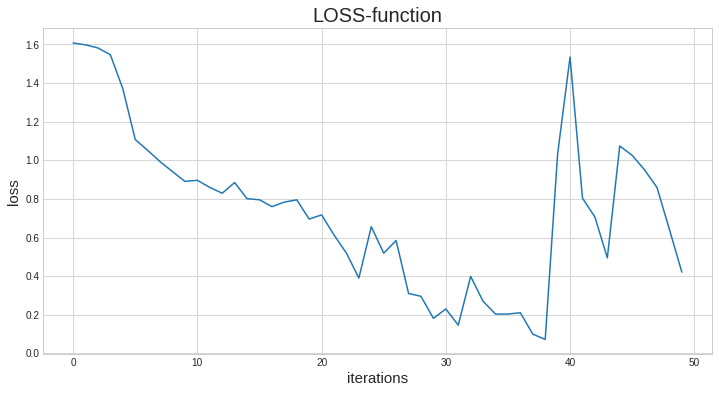

In [7]:
# create figure
mpl.style.use("seaborn-whitegrid")
plt.figure(figsize=(12,6))
# create plot
plt.plot(all_losses)
# title and labels
plt.title("LOSS-function", fontsize=20)
plt.xlabel("iterations", fontsize=15)
plt.ylabel("loss", fontsize=15)
# show plot
plt.show()

## Save model

In [8]:
%cd ../models/
FILE = "2.3-lstm-cell-network-model.pth"
torch.save(model.state_dict(), FILE)
%cd ../notebooks/

## Load model

In [5]:
%cd ../models/
FILE = "2.3-lstm-cell-network-model.pth"
loaded_model = RNN(input_size, hidden_size, n_characters).to(device)
loaded_model.load_state_dict(torch.load(FILE, map_location=device))
loaded_model.eval()
%cd ../notebooks/

RNN(
  (lstmcell): LSTMCell(3, 128)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Determine accuracy

characters in test data:  ['a', 'e', 'i', 'o', 'u']
../data/test\a__88470.csv / a ✓
../data/test\a__94789.csv / a ✓
../data/test\a__96486.csv / a ✓
../data/test\a__97545.csv / a ✓
../data/test\a__98539.csv / a ✓
../data/test\e__70433.csv / e ✓
../data/test\e__76682.csv / e ✓
../data/test\e__82254.csv / e ✓
../data/test\e__83191.csv / e ✓
../data/test\e__84585.csv / e ✓
../data/test\i__75461.csv / i ✓
../data/test\i__81833.csv / i ✓
../data/test\i__88644.csv / i ✓
../data/test\i__89095.csv / i ✓
../data/test\i__91889.csv / i ✓
../data/test\o__54903.csv / o ✓
../data/test\o__63253.csv / o ✓
../data/test\o__67824.csv / a ✗ (o)
../data/test\o__72419.csv / o ✓
../data/test\o__76748.csv / o ✓
../data/test\u__81848.csv / u ✓
../data/test\u__82120.csv / a ✗ (u)
../data/test\u__83897.csv / u ✓
../data/test\u__85976.csv / u ✓
../data/test\u__88458.csv / u ✓
../data/test\u__93521.csv / u ✓

accuracy = 92.31 %



<ipython-input-7-ea5ba8b87f0e>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_characters, rotation=90)
<ipython-input-7-ea5ba8b87f0e>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_characters)


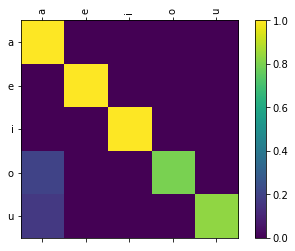

In [7]:
# load test dataset
character_files, all_characters = load_data(path="../data/test/")
print("characters in test data: ", all_characters)

# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_characters, n_characters)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for character in all_characters:
        # all files from one character
        for file in character_files[character]:

            file_tensor = file_to_tensor(file).to(device)

            hidden, cell = loaded_model.init_hidden()
            hidden = hidden.to(device)
            cell = cell.to(device)

            # iterate over seq_lenght to get last output
            for i in range(file_tensor.size()[0]):
                output, hidden, cell = loaded_model(file_tensor[i], hidden, cell)
                output = output.to(device)
                hidden = hidden.to(device)
                cell = cell.to(device)

            # get character from output
            guess = character_from_output(output)
            n_samples += 1
            if guess == character:
                n_correct += 1
                correct = "✓"
            else:
                correct = "✗ (%s)" % character
            confusion[all_characters.index(character)][all_characters.index(guess)] += 1
            
            print(file, "/", guess, correct)

# normalize by dividing every row by its sum
for i in range(n_characters):
    confusion[i] = confusion[i] / confusion[i].sum()

acc = 100.0 * n_correct / n_samples
print(f"\naccuracy = {acc:.2f} %\n")

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# set up axes
ax.set_xticklabels([''] + all_characters, rotation=90)
ax.set_yticklabels([''] + all_characters)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()